In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, size = 5000, dim = 40, random_offset = 0):
        super(MyDataset, self).__init__()
        self.size = size
        self.dim = dim
        self.random_offset = random_offset
        
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('{}index out of range'.format(self, __class__, __name__))
            
        rng_state = torch.get_rng_state()
        torch.manual_seed(index + self.random_offset)
        
        while True:
            img = torch.zeros(self.dim, self.dim)
            dx = torch.randint(-10,10,(1,),dtype = torch.float)
            dy = torch.randint(-10,10,(1,),dtype = torch.float)
            c = torch.randint(-20,20,(1,),dtype = torch.float)
            
            params = torch.cat((dy/dx, c))
            xy = torch.randint(0, img.shape[1], (20,2), dtype = torch.float)
            xy[:,1] = xy[:,0] * params[0] + params[1]
            
            xy.round_()
            xy = xy[ xy[:,1]>0 ]
            xy = xy[ xy[:,1]<self.dim ]
            xy = xy[ xy[:,0]<self.dim ]
            
            for i in range(xy.shape[0]):
                x,y = xy[i][0],self.dim - xy[i][1]
                img[int(y), int(x)] = 1
            if img.sum() > 2:
                break
        torch.set_rng_state(rng_state)
        return img.unsqueeze(0), params
    
    def __len__(self):
        return self.size


In [2]:
train_data  =  MyDataset()
val_data = MyDataset(size = 500, random_offset = 33333)
test_data = MyDataset(size = 500, random_offset = 99999)


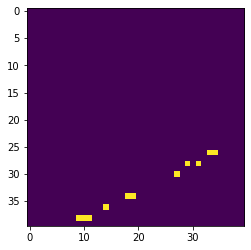

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_data[3][0].squeeze())


In [4]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchbearer import Trial

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=True)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48 * 40**2, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        #print(out.shape)
        return out

In [6]:
# build the model
model = SimpleCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss(reduction="mean") #L1Loss(reduction='mean')##CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())


trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, valloader,test_generator=testloader)
tr_results = trial.run(epochs=100)

te_results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(tr_results[-1], te_results)


{'running_loss': 0.6847435832023621, 'running_mse': 0.6847435832023621, 'loss': 0.6416553854942322, 'mse': 0.6517828106880188, 'val_loss': 16.554733276367188, 'val_mse': 16.494070053100586, 'train_steps': 40, 'validation_steps': 4, 'test_loss': 16.36819839477539, 'test_mse': 16.45986557006836} {'test_loss': 16.36819839477539, 'test_mse': 16.45986557006836}


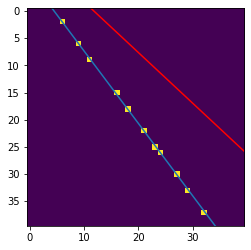

In [7]:
model = model.eval() 

i = 48
im,target = (test_data[i][0],test_data[i][1])  
batch = im.to(device).unsqueeze(0)
predictions = model(batch)

#Inverse the img
im2 = torch.zeros_like(im)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im2[im.shape[0]-i-1,im.shape[1]-j-1] = im[i,j]
        
x1 = 0
x2 = 40
bias = -1
y1 = x1 * target[0] + target[1] + bias
y2 = x2 * target[0] + target[1] + bias
y3 = x1 * predictions[0][0] + predictions[0][1] + bias
y4 = x2 * predictions[0][0] + predictions[0][1] + bias

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.plot([x1,x2],[y1,y2])
ax.plot([x1,x2],[y3,y4],c='r')
#ax.imshow(im.squeeze(), cmap=plt.get_cmap('gray'))
ax.imshow(im2.squeeze())

In [8]:
因本任务的目标是regression，因而选用MSE 常用于回归任务的
trainingloss = 2 


训练集误差从62一直减小至2
验证误差起初53，并随着训练减小 但当小于约22时不再继续减少，开始波动，最终在23趋于稳定 
由训练集和验证集的差可以看出有明显的过拟合
测试集误差17.19

从结果来看，少部分直线几乎完全重合，大部分有微小偏离，也有一些偏离程度较大
平均误差较为明显，肉眼可见


SyntaxError: invalid character in identifier (<ipython-input-8-94cbbd0ec3ac>, line 1)

In [9]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48 * 2**2, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out,(2,2)) 
        out = out.view(out.shape[0], -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        #print(out.shape)
        return out

In [10]:
# build the model
model2 = BetterCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss(reduction="mean") #L1Loss(reduction='mean')##CrossEntropyLoss()
optimiser = optim.Adam(model2.parameters())


trial = Trial(model2, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, valloader,test_generator=testloader, val_steps=10)

tr_results = trial.run(epochs=100)

te_results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(tr_results[-1], te_results)


{'running_loss': 3.961540699005127, 'running_mse': 3.961540699005127, 'loss': 3.9215571880340576, 'mse': 3.951648712158203, 'val_loss': 4.509390830993652, 'val_mse': 4.523552417755127, 'train_steps': 40, 'validation_steps': 10, 'test_loss': 5.57876443862915, 'test_mse': 5.573469638824463} {'test_loss': 5.57876443862915, 'test_mse': 5.573469638824463}


In [ ]:
比起Simple model过拟合较少，
训练集误差从起初的59降到3.77 
验证集误差在第77个epoch就到达4.2左右，随后一直波动，比Simple model少了18
测试集误差为 4.91  ，decrease by  ，

按resultant图片来看，测试集上的线普遍有slight偏离
但也有偏差过大的，比如

总体来说本模型相比之前的有较大提升


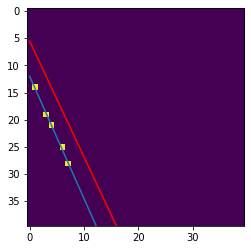

In [11]:
model2 = model2.eval() 

i = 3
im,target = (val_data[i][0],val_data[i][1])  #4可改
batch = im.to(device).unsqueeze(0)
predictions = model2(batch)

#Inverse the img
im2 = torch.zeros_like(im)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im2[im.shape[0]-i-1,im.shape[1]-j-1] = im[i,j]
        
x1 = 0
x2 = 40
bias = -1
y1 = x1 * target[0] + target[1] + bias
y2 = x2 * target[0] + target[1] + bias
y3 = x1 * predictions[0][0] + predictions[0][1] + bias
y4 = x2 * predictions[0][0] + predictions[0][1] + bias

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.plot([x1,x2],[y1,y2])
ax.plot([x1,x2],[y3,y4],c='r')
#ax.imshow(im.squeeze(), cmap=plt.get_cmap('gray'))
ax.imshow(im2.squeeze())

In [12]:
class BestCNN(nn.Module):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(48, 48, (3, 3), padding=1)
        self.fc1 = nn.Linear(48 * 2**2, 128)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):
        idxx = torch. repeat_interleave( 
            torch.arange(-20, 20, dtype=torch. float).unsqueeze(0) / 40.0,
            repeats=40, dim=0).to(x.device) 
        idxy = idxx.clone(). t() 
        idx = torch.stack([idxx , idxy ]).unsqueeze(0) 
        idx = torch.repeat_interleave(idx , repeats=x.shape[0] , dim=0) 
        x = torch.cat([x, idx] , dim=1)
        out = self.conv1(x) #40，40
        out = F.relu(out) 
        out = self.conv2(out) #40，40
        out = F.relu(out)
        out = F.adaptive_max_pool2d(out,(2,2)) #2*2
        out = out.view(out.shape[0], -1)
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        #print(out.shape)
        return out

In [13]:
model3 = BestCNN()

# define the loss function and the optimiser
loss_function = nn.MSELoss(reduction="mean") #L1Loss(reduction='mean')##CrossEntropyLoss()
optimiser = optim.Adam(model3.parameters())


trial = Trial(model3, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader, valloader,test_generator=testloader, val_steps=10)

tr_results = trial.run(epochs=100)

te_results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(tr_results[-1], te_results)


{'running_loss': 1.753998875617981, 'running_mse': 1.753998875617981, 'loss': 1.7008850574493408, 'mse': 1.7339298725128174, 'val_loss': 1.829809546470642, 'val_mse': 1.825762152671814, 'train_steps': 40, 'validation_steps': 10, 'test_loss': 2.5465590953826904, 'test_mse': 2.5554139614105225} {'test_loss': 2.5465590953826904, 'test_mse': 2.5554139614105225}


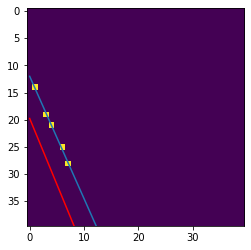

In [14]:
model = model.eval() 

i = 3
im,target = (val_data[i][0],val_data[i][1])  #4可改
batch = im.to(device).unsqueeze(0)
predictions = model(batch)

#Inverse the img
im2 = torch.zeros_like(im)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im2[im.shape[0]-i-1,im.shape[1]-j-1] = im[i,j]
        
x1 = 0
x2 = 40
bias = -1
y1 = x1 * target[0] + target[1] + bias
y2 = x2 * target[0] + target[1] + bias
y3 = x1 * predictions[0][0] + predictions[0][1] + bias
y4 = x2 * predictions[0][0] + predictions[0][1] + bias


fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.plot([x1,x2],[y1,y2])
ax.plot([x1,x2],[y3,y4],c='r')
#ax.imshow(im.squeeze(), cmap=plt.get_cmap('gray'))
ax.imshow(im2.squeeze())

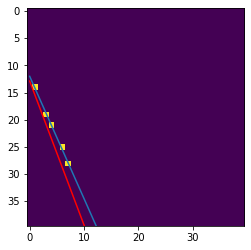

In [15]:
model3 = model3.eval() 

i = 3
im,target = (val_data[i][0],val_data[i][1])
batch = im.to(device).unsqueeze(0)
predictions = model3(batch)

#Inverse the img
im2 = torch.zeros_like(im)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im2[im.shape[0]-i-1,im.shape[1]-j-1] = im[i,j]
        
x1 = 0
x2 = 40
bias = -1
y1 = x1 * target[0] + target[1] + bias
y2 = x2 * target[0] + target[1] + bias
y3 = x1 * predictions[0][0] + predictions[0][1] + bias
y4 = x2 * predictions[0][0] + predictions[0][1] + bias

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.plot([x1,x2],[y1,y2])
ax.plot([x1,x2],[y3,y4],c='r')
#ax.imshow(im.squeeze(), cmap=plt.get_cmap('gray'))
ax.imshow(im2.squeeze())